<a href="https://colab.research.google.com/github/fa7ih/surucuyorgunluk/blob/main/vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from timm import create_model
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from PIL import Image

data_dir = '/content/dataset'
categories = ['Drowsy', 'NonDrowsy']

class CustomDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

all_filepaths = []
all_labels = []
for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        filepath = os.path.join(category_dir, filename)
        all_filepaths.append(filepath)
        all_labels.append(i)  # Integer formatında kategoriler

kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_metrics = []

class ViTModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.backbone = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.backbone(x)

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, accuracy, all_preds, all_labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(categories)

for fold, (train_index, val_index) in enumerate(kf.split(all_filepaths)):
    print(f"Fold {fold + 1}")

    train_filepaths = np.array(all_filepaths)[train_index]
    train_labels = np.array(all_labels)[train_index]
    val_filepaths = np.array(all_filepaths)[val_index]
    val_labels = np.array(all_labels)[val_index]

    train_dataset = CustomDataset(train_filepaths, train_labels, transform=transform)
    val_dataset = CustomDataset(val_filepaths, val_labels, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

    model = ViTModel(num_classes=num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 5
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, val_preds, val_labels = validate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    save_path = f'vit_model_fold_{fold + 1}.pth'
    torch.save(model.state_dict(), save_path)
    print(f"Model fold {fold + 1} olarak {save_path} dosyasına kaydedildi.")



Fold 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/5, Train Loss: 0.0882, Val Loss: 0.0026, Val Accuracy: 0.9993
Epoch 2/5, Train Loss: 0.0118, Val Loss: 0.0278, Val Accuracy: 0.9901
Epoch 3/5, Train Loss: 0.0047, Val Loss: 0.0103, Val Accuracy: 0.9969
Epoch 4/5, Train Loss: 0.0066, Val Loss: 0.0028, Val Accuracy: 0.9993
Epoch 5/5, Train Loss: 0.0015, Val Loss: 0.0065, Val Accuracy: 0.9984
Model fold 1 olarak vit_model_fold_1.pth dosyasına kaydedildi.
Fold 2
Epoch 1/5, Train Loss: 0.1783, Val Loss: 0.0127, Val Accuracy: 0.9959
Epoch 2/5, Train Loss: 0.0271, Val Loss: 0.0050, Val Accuracy: 0.9981
Epoch 3/5, Train Loss: 0.0115, Val Loss: 0.0030, Val Accuracy: 0.9988
Epoch 4/5, Train Loss: 0.0073, Val Loss: 0.0005, Val Accuracy: 0.9999
Epoch 5/5, Train Loss: 0.0037, Val Loss: 0.0013, Val Accuracy: 0.9996
Model fold 2 olarak vit_model_fold_2.pth dosyasına kaydedildi.
Fold 3
Epoch 1/5, Train Loss: 0.1527, Val Loss: 0.0034, Val Accuracy: 0.9989
Epoch 2/5, Train Loss: 0.0157, Val Loss: 0.0424, Val Accuracy: 0.9860
Epoch 3/5, Train Los

In [6]:
!pip install torch-xla==2.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 MB 23.1 MB/s eta 0:00:00


In [7]:
!pip install torch-xla torch-xla-core


ERROR: Could not find a version that satisfies the requirement torch-xla-core (from versions: none)
ERROR: No matching distribution found for torch-xla-core


In [5]:
!pip install playsound


  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=ae1209eb0f8b44c5e3c6f477635103063579483c4b7ac59862275e10502a3e81
  Stored in directory: /root/.cache/pip/wheels/90/89/ed/2d643f4226fc8c7c9156fc28abd8051e2d2c0de37ae51ac45c
Successfully built playsound


In [9]:
import pandas as pd

data = {
    'Fold': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5],
    'Epoch': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'Train Loss': [0.0882, 0.0118, 0.0047, 0.0066, 0.0015, 0.1783, 0.0271, 0.0115, 0.0073, 0.0037,
                   0.1527, 0.0157, 0.0056, 0.0053, 0.0075, 0.0897, 0.0099, 0.0069, 0.0040, 0.0057,
                   0.1556, 0.0085, 0.0050, 0.0034, 0.0100],
    'Val Loss': [0.0026, 0.0278, 0.0103, 0.0028, 0.0065, 0.0127, 0.0050, 0.0030, 0.0005, 0.0013,
                 0.0034, 0.0424, 0.0040, 0.1276, 0.0040, 0.0144, 0.0334, 0.0198, 0.0056, 0.0020,
                 0.0051, 0.0021, 0.0028, 0.0002, 0.0023],
    'Val Accuracy': [0.9993, 0.9901, 0.9969, 0.9993, 0.9984, 0.9959, 0.9981, 0.9988, 0.9999, 0.9996,
                     0.9989, 0.9860, 0.9987, 0.9639, 0.9983, 0.9963, 0.9874, 0.9933, 0.9982, 0.9994,
                     0.9984, 0.9996, 0.9992, 0.9999, 0.9994]
}

df = pd.DataFrame(data)

df.to_csv('/content/makine/dataframe.csv', index=False)


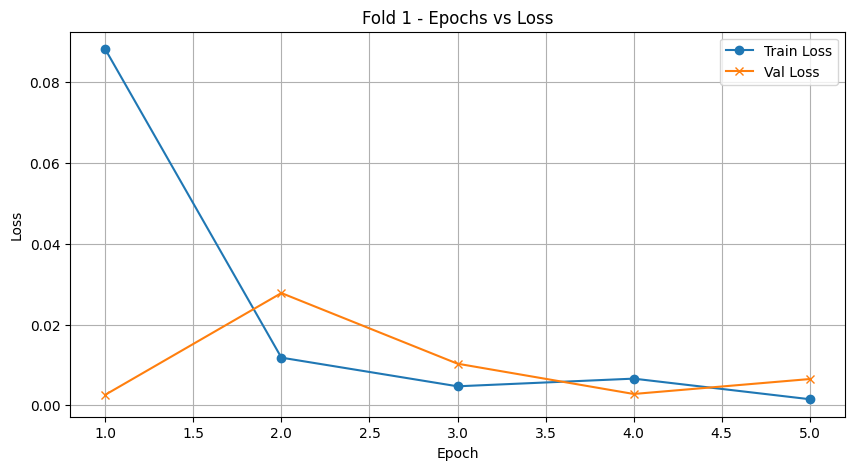

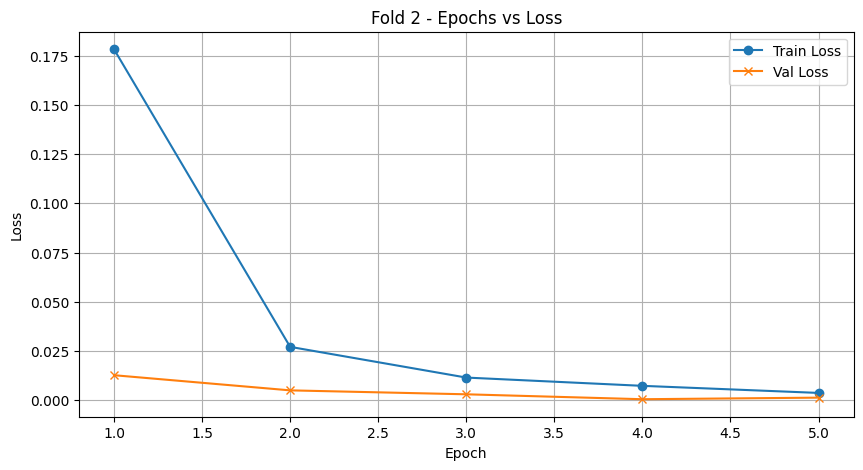

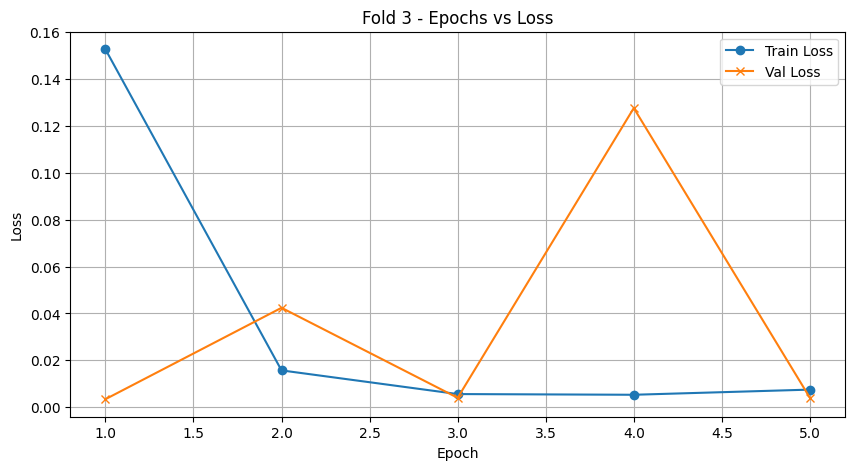

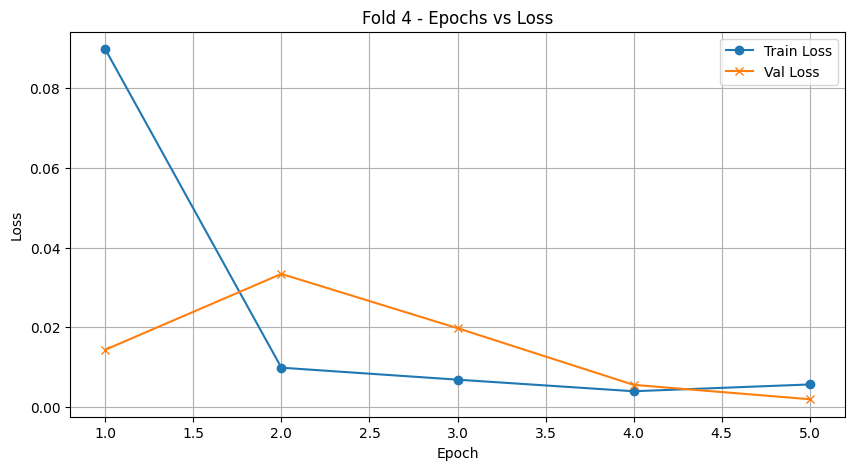

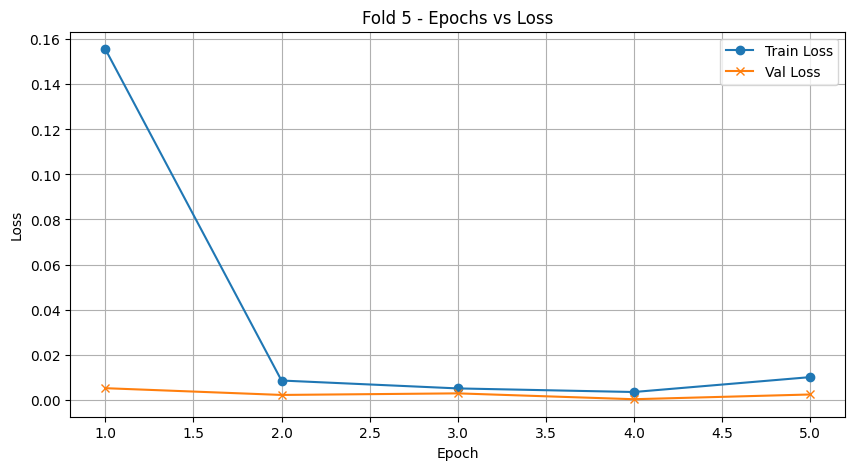

In [10]:
import matplotlib.pyplot as plt

data = {
    'Fold': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5],
    'Epoch': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'Train Loss': [0.0882, 0.0118, 0.0047, 0.0066, 0.0015, 0.1783, 0.0271, 0.0115, 0.0073, 0.0037,
                   0.1527, 0.0157, 0.0056, 0.0053, 0.0075, 0.0897, 0.0099, 0.0069, 0.0040, 0.0057,
                   0.1556, 0.0085, 0.0050, 0.0034, 0.0100],
    'Val Loss': [0.0026, 0.0278, 0.0103, 0.0028, 0.0065, 0.0127, 0.0050, 0.0030, 0.0005, 0.0013,
                 0.0034, 0.0424, 0.0040, 0.1276, 0.0040, 0.0144, 0.0334, 0.0198, 0.0056, 0.0020,
                 0.0051, 0.0021, 0.0028, 0.0002, 0.0023],
    'Val Accuracy': [0.9993, 0.9901, 0.9969, 0.9993, 0.9984, 0.9959, 0.9981, 0.9988, 0.9999, 0.9996,
                     0.9989, 0.9860, 0.9987, 0.9639, 0.9983, 0.9963, 0.9874, 0.9933, 0.9982, 0.9994,
                     0.9984, 0.9996, 0.9992, 0.9999, 0.9994]
}

folds = sorted(set(data['Fold']))
for fold in folds:
    fold_data = {k: [v for i, v in enumerate(data[k]) if data['Fold'][i] == fold] for k in data}
    epochs = fold_data['Epoch']
    train_losses = fold_data['Train Loss']
    val_losses = fold_data['Val Loss']

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold} - Epochs vs Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

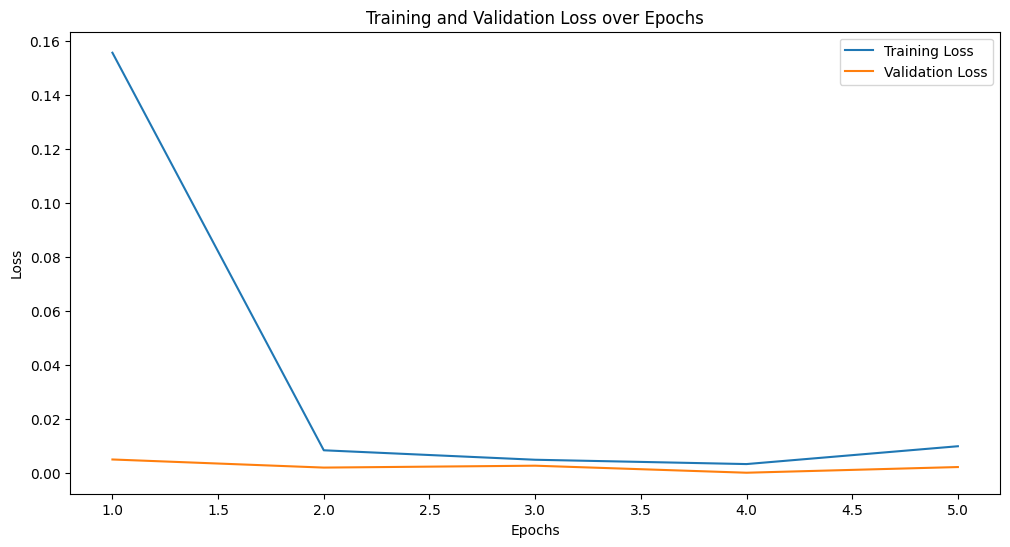

In [11]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [13]:
import os

data_dir = '/content/dataset'

categories = ['Drowsy', 'NonDrowsy']

all_filepaths = []
all_labels = []

for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(('jpg', 'png', 'jpeg')):
            filepath = os.path.join(category_dir, filename)
            all_filepaths.append(filepath)
            all_labels.append(i)


train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
    all_filepaths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)


In [25]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
from timm import create_model

class CustomDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

class ViTModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.backbone = create_model('vit_base_patch16_224', pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.backbone(x)

class MetricsEvaluator:
    def __init__(self, model_path, val_loader, num_classes=2):
        self.model = ViTModel(num_classes=num_classes)
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        self.model.to(device)
        self.val_loader = val_loader

    def evaluate(self):
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)[:, 1]

                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        auc = roc_auc_score(all_labels, all_probs)

        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall

        metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall (Sensitivity)': sensitivity,
            'Specificity': specificity,
            'F1-Score': f1,
            'AUC': auc
        }
        return metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/dataset'
categories = ['Drowsy', 'NonDrowsy']

all_filepaths = []
all_labels = []
for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        filepath = os.path.join(category_dir, filename)
        all_filepaths.append(filepath)
        all_labels.append(i)

all_filepaths = np.array(all_filepaths)
all_labels = np.array(all_labels)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_fold_metrics = []

for fold, (train_index, val_index) in enumerate(kf.split(all_filepaths)):
    print(f"Evaluating Fold {fold + 1}")

    val_filepaths = all_filepaths[val_index]
    val_labels = all_labels[val_index]

    val_dataset = CustomDataset(val_filepaths, val_labels, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

    model_path = f'vit_model_fold_{fold + 1}.pth'  # Eğitilen model dosya yolu
    evaluator = MetricsEvaluator(model_path, val_loader, num_classes=len(categories))
    metrics = evaluator.evaluate()
    print(f"Fold {fold + 1} Metrics: {metrics}")
    all_fold_metrics.append(metrics)

avg_metrics = {metric: np.mean([fold_metrics[metric] for fold_metrics in all_fold_metrics]) for metric in all_fold_metrics[0]}
print("\nAverage Metrics Across All Folds:")
print(avg_metrics)


Evaluating Fold 1


<ipython-input-25-27a24c09b2bc>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


Fold 1 Metrics: {'Accuracy': 0.9972484746979303, 'Precision': 0.9940275253180992, 'Recall (Sensitivity)': 1.0, 'Specificity': 0.9949238578680203, 'F1-Score': 0.9970048183357207, 'AUC': 0.9999994234539398}
Evaluating Fold 2


<ipython-input-25-27a24c09b2bc>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


Fold 2 Metrics: {'Accuracy': 0.9995214738605096, 'Precision': 0.9992325402916347, 'Recall (Sensitivity)': 0.9997440491425647, 'Specificity': 0.9993261455525606, 'F1-Score': 0.9994882292732856, 'AUC': 0.9999997125439606}
Evaluating Fold 3


<ipython-input-25-27a24c09b2bc>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


Fold 3 Metrics: {'Accuracy': 0.9995214738605096, 'Precision': 0.9994863893168978, 'Recall (Sensitivity)': 0.9994863893168978, 'Specificity': 0.999552071668533, 'F1-Score': 0.9994863893168978, 'AUC': 0.9999987921809244}
Evaluating Fold 4


<ipython-input-25-27a24c09b2bc>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


Fold 4 Metrics: {'Accuracy': 0.9984446039722422, 'Precision': 0.9969742813918305, 'Recall (Sensitivity)': 0.9997471554993679, 'Specificity': 0.9972745855098796, 'F1-Score': 0.9983587930816816, 'AUC': 0.999898127153277}
Evaluating Fold 5


<ipython-input-25-27a24c09b2bc>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


Fold 5 Metrics: {'Accuracy': 0.9988035415171094, 'Precision': 0.9976738175239079, 'Recall (Sensitivity)': 0.9997409997409997, 'Specificity': 0.9979986657771848, 'F1-Score': 0.9987063389391979, 'AUC': 0.9999780566825263}

Average Metrics Across All Folds:
{'Accuracy': 0.9987079135816602, 'Precision': 0.9974789107684741, 'Recall (Sensitivity)': 0.999743718739966, 'Specificity': 0.9978150652752357, 'F1-Score': 0.9986089137893568, 'AUC': 0.9999748224029258}


In [ ]:
!pip install onnx_tf

In [ ]:
!curl --output "/content/makine/haarcascade_frontalface_alt.xml" https://cdn.hackaday.io/files/275521178784768/haarcascade_frontalface_alt.xml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  898k  100  898k    0     0  11.2M      0 --:--:-- --:--:-- --:--:-- 11.3M


In [ ]:
def inference(model, dataloader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)


In [ ]:
!pip install timm
!pip install torch torchvision
!pip install numpy pandas matplotlib seaborn scikit-learn